# Final Project - Real Estate Sale Price

For my final project, I chose to use unsupervised learning to predict the sale price of a house given a variety of inputs. The use case would be to provide interested sellers and their real estate agents with an estimate of their listing price.

## Setup

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [30]:
train_data = pd.read_csv('train.csv')
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Data Cleaning

In [31]:
train_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [32]:
def clean(df):
    percentages = [i/len(df) for i in df.isnull().sum()]
    CCA = pd.DataFrame({'features': df.columns, 'percentage_missing': percentages})
    impute = []
    throw = []
    for i in np.arange(len(CCA)):
        if CCA['percentage_missing'][i] > 0.1:
            throw.append(CCA['features'][i])
        elif CCA['percentage_missing'][i] > 0 and CCA['percentage_missing'][i] <= 0.05:
            impute.append(CCA['features'][i])
        else:
            continue

    features_to_impute = impute
    features_to_throw = throw
    temp_df = df.drop(features_to_throw, 1)
    impute_dict = {}
    for i in features_to_impute:
        if temp_df[i].dtype == float:
            impute_dict[i] = temp_df[i].median()
        else:
            impute_dict[i] = temp_df[i].mode().iloc[0]
    temp_df = temp_df.fillna(value=impute_dict)
    return temp_df

In [33]:
def numeric(df):
    new_df = pd.DataFrame()
    for col in df.columns:
        if type(df[col][0]) != str:
            new_df[col] = df[col]
        else:
            continue
    return new_df

In [34]:
train_data = clean(train_data)
train_data.head()

/var/folders/5c/fd850vrj48v7jb6xpw9dy4v00000gn/T/ipykernel_69764/3916390727.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_df = df.drop(features_to_throw, 1)


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [35]:
numeric_train_data = numeric(train_data)
numeric_train_data.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


## Exploratory Data Analysis

(array([605., 160., 359.,  94.,  52.,  87.,   0.,   0.,  63.,  40.]),
 array([ 20.,  37.,  54.,  71.,  88., 105., 122., 139., 156., 173., 190.]),
 <BarContainer object of 10 artists>)

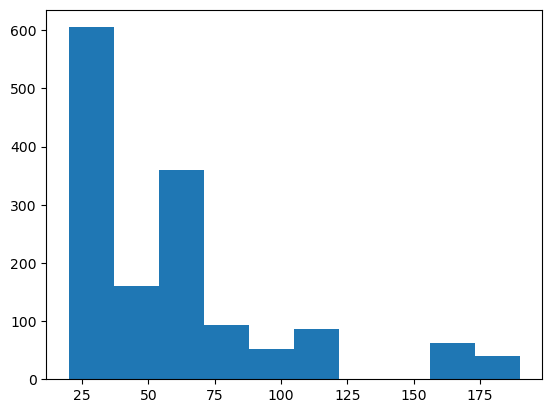

In [36]:
plt.hist(train_data['MSSubClass'])

(array([1.423e+03, 2.400e+01, 8.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([  1300. ,  22694.5,  44089. ,  65483.5,  86878. , 108272.5,
        129667. , 151061.5, 172456. , 193850.5, 215245. ]),
 <BarContainer object of 10 artists>)

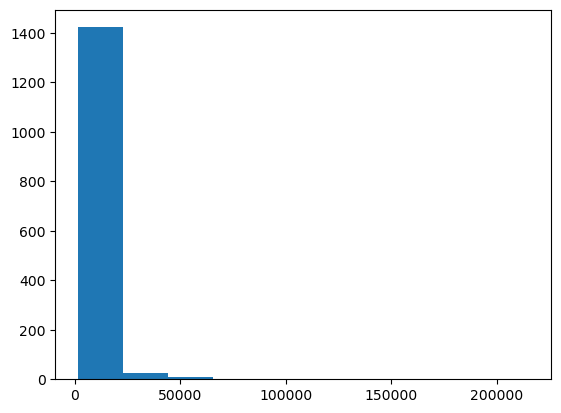

In [37]:
plt.hist(train_data['LotArea'])

<Axes: xlabel='BedroomAbvGr', ylabel='SalePrice'>

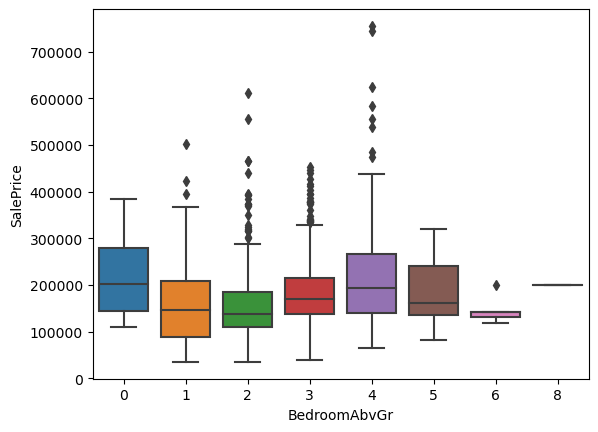

In [38]:
sns.boxplot(y='SalePrice',x='BedroomAbvGr',data=train_data)

## PCA Preprocessing

In [39]:
to_drop = []
for col in numeric_train_data.columns:
    if np.any(np.isnan(numeric_train_data[col])) == True:
        to_drop.append(col)
numeric_train_data = numeric_train_data.drop(to_drop, 1)

/var/folders/5c/fd850vrj48v7jb6xpw9dy4v00000gn/T/ipykernel_69764/3182981199.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  numeric_train_data = numeric_train_data.drop(to_drop, 1)


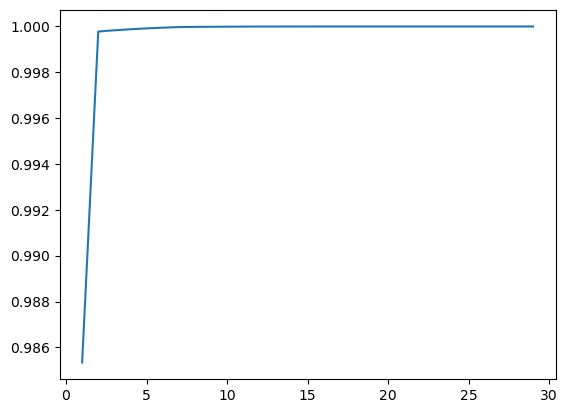

In [40]:
components = list(range(1, 30))
variance_ratio = []
for i in components:
    pca = PCA(n_components=i).fit(numeric_train_data)
    x_reduced = PCA(n_components=i).fit_transform(numeric_train_data)
    variance_ratio.append(sum(pca.explained_variance_ratio_))
plt.plot(components, variance_ratio)

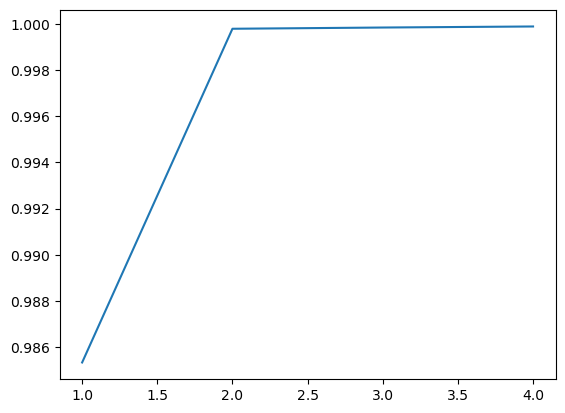

In [41]:
num_components = list(range(1, 5))
variance_ratio = []
for i in num_components:
    pca = PCA(n_components=i).fit(numeric_train_data)
    x_reduced = PCA(n_components=i).fit_transform(numeric_train_data)
    variance_ratio.append(sum(pca.explained_variance_ratio_))
plt.plot(num_components, variance_ratio)

As seen in the graph above, 2 components captures the vast majority of the variance in this dataset. Given that information, I created a new dataframe containing the PCA values. Ultimately, I will feed this into the k-means clustering algorithm to break out the data into clusters.

In [42]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(numeric_train_data)
pca_df_train = pd.DataFrame(
    data=pca_features, 
    columns=['PC1', 'PC2'],
    dtype=float)
new_pc1 = [float(i) for i in pca_df_train['PC1']]
new_pc2 = [float(i) for i in pca_df_train['PC2']]
pca_df_train.head()

,PC1,PC2
0,27493.523736,-2993.914641
1,547.725922,-929.997186
2,42579.460424,-701.918117
3,-40929.738935,409.263624
4,69169.762247,1418.332744


## K-Means Clustering (without PCA)


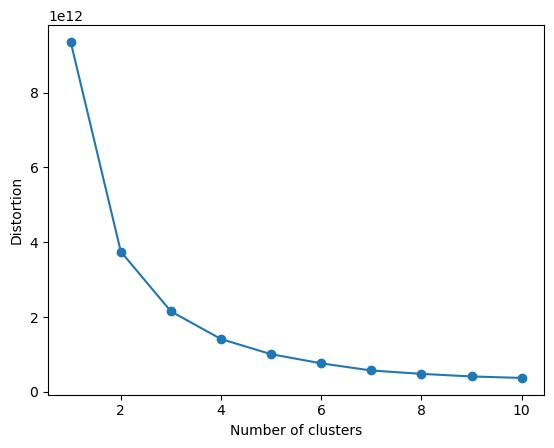

In [43]:
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(numeric_train_data)
    distortions.append(km.inertia_)

plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [44]:
km = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(numeric_train_data)

<Axes: ylabel='SalePrice'>

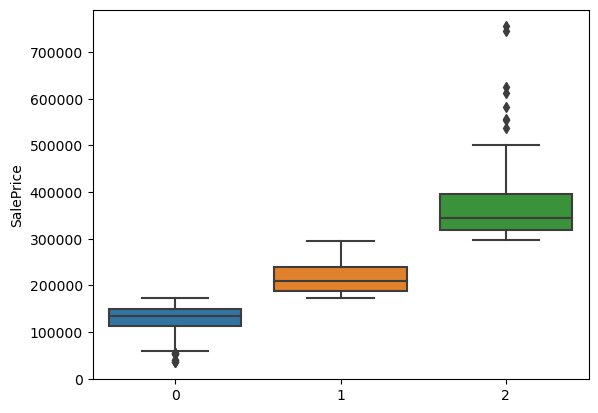

In [45]:
sns.boxplot(x = km.labels_, y = numeric_train_data['SalePrice'])

## K-Means Clustering (with PCA)

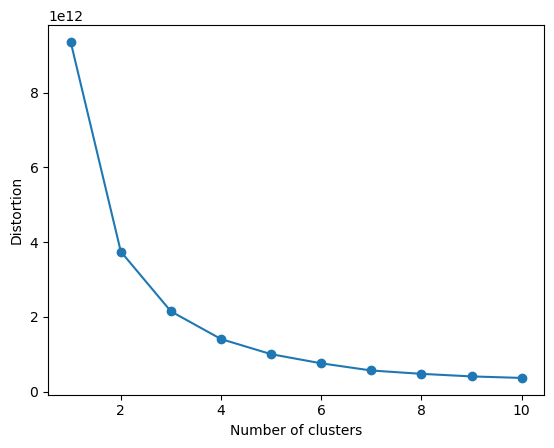

In [46]:
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(pca_df_train)
    distortions.append(km.inertia_)

plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [47]:
km = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(pca_df_train)

<Axes: >

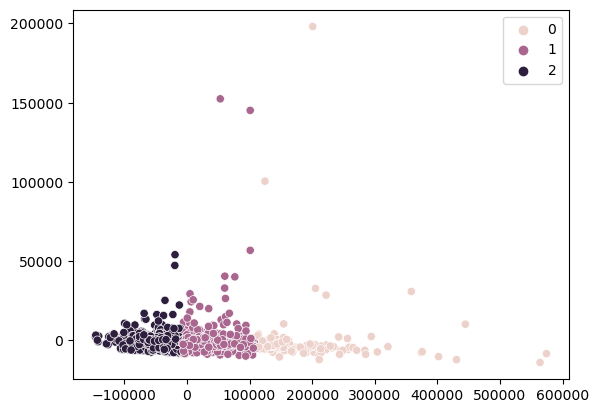

In [48]:
sns.scatterplot(x = new_pc1, y = new_pc2, hue = km.labels_)

<Axes: ylabel='SalePrice'>

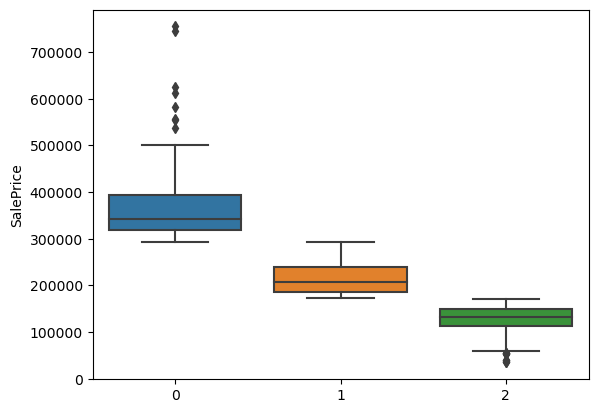

In [49]:
sns.boxplot(x = km.labels_, y = numeric_train_data['SalePrice'])

## Discussion and Conclusion

In conclusion, this model uses kmeans clustering to provide accurate estimates of house price based on a variety of features. As shown above (disregardng the opposite labeling in the two kmeans methods), the models using principal component analysis and not both came to very similar conclusions regarding the sales price clusters found in the data.